In [3]:
import time
import csv
import re

import numpy as np
import pandas as pd
import requests
import lxml.etree as xml

import pprint
import ast
import glob

import googlesearch
from googlesearch import search

import bs4
from bs4 import BeautifulSoup

from tqdm.auto import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

In [2]:
companies = ["Harley-Davidson Inc. (Ticker: HOG)",
"Amtek Auto Ltd",
"Renault SA (Ticker: RNO)",
"Continental AG (Ticker: CON)",
"The Kroger Co. (Ticker: KR)",
"Yonghui Superstores Co. Ltd. (Ticker: 601933)",
"Carrefour SA (Ticker: CA)",
"Tesco PLC (Ticker: TSCO)",
"Ford Motor Company (Ticker: F)",
]

companies = {k:v for k,v in enumerate(companies)}

companies = pd.DataFrame(companies.items(), columns=['id','company'])

companies.head()

,id,company
0,0,Harley-Davidson Inc. (Ticker: HOG)
1,1,Amtek Auto Ltd
2,2,Renault SA (Ticker: RNO)
3,3,Continental AG (Ticker: CON)
4,4,The Kroger Co. (Ticker: KR)


In [3]:
def name_convert(text):
    text = text.split('(')[0]
    searchval = 'companiesmarketcap marketcap '+ text
    links = []
    try:
        for url in search(searchval, lang='en', num_results=3):
            links.append(url)
    except:
        return []
    links = [x if 'companiesmarketcap.com/' in x else '' for x in links]
    links = [x for x in links if x]
    tickers = []
    for link in links:
        try:
            link = str(link)
            link = link.split("companiesmarketcap.com/")[1]
            tickers.append(link)
        except:
            continue
    return list(set(tickers))

In [4]:
companies['marketcap_tickers'] = companies.company.progress_apply(name_convert)
companies['found'] = companies.marketcap_tickers.apply(lambda x: len(x)>0)
companies

100%|██████████| 9/9 [00:15<00:00,  1.72s/it]


,id,company,marketcap_tickers,found
0,0,Harley-Davidson Inc. (Ticker: HOG),[harley-davidson/marketcap/],True
1,1,Amtek Auto Ltd,[ametek/marketcap/],True
2,2,Renault SA (Ticker: RNO),[renault/marketcap/],True
3,3,Continental AG (Ticker: CON),[continental/marketcap/],True
4,4,The Kroger Co. (Ticker: KR),"[kroger/marketcap/, kroger/revenue/]",True
5,5,Yonghui Superstores Co. Ltd. (Ticker: 601933),[],False
6,6,Carrefour SA (Ticker: CA),[carrefour/marketcap/],True
7,7,Tesco PLC (Ticker: TSCO),"[tesco/marketcap/, tesco/pe-ratio/]",True
8,8,Ford Motor Company (Ticker: F),[ford/marketcap/],True


In [5]:
companies = companies[companies.found].astype('str')
companies

,id,company,marketcap_tickers,found
0,0,Harley-Davidson Inc. (Ticker: HOG),['harley-davidson/marketcap/'],True
1,1,Amtek Auto Ltd,['ametek/marketcap/'],True
2,2,Renault SA (Ticker: RNO),['renault/marketcap/'],True
3,3,Continental AG (Ticker: CON),['continental/marketcap/'],True
4,4,The Kroger Co. (Ticker: KR),"['kroger/marketcap/', 'kroger/revenue/']",True
6,6,Carrefour SA (Ticker: CA),['carrefour/marketcap/'],True
7,7,Tesco PLC (Ticker: TSCO),"['tesco/marketcap/', 'tesco/pe-ratio/']",True
8,8,Ford Motor Company (Ticker: F),['ford/marketcap/'],True


In [6]:
def get_ticker(lst):
    if isinstance(lst, str):
        lst = ast.literal_eval(lst)
    if len(lst)==0:
        return None
    lst = [x.split('/')[0] for x in lst]
    lst = [x for x in lst if x!='']
    return list(set(lst))

In [7]:
companies['marketcap_tickers'] = companies.marketcap_tickers.progress_apply(get_ticker)
companies

100%|██████████| 8/8 [00:00<00:00, 5590.54it/s]


,id,company,marketcap_tickers,found
0,0,Harley-Davidson Inc. (Ticker: HOG),[harley-davidson],True
1,1,Amtek Auto Ltd,[ametek],True
2,2,Renault SA (Ticker: RNO),[renault],True
3,3,Continental AG (Ticker: CON),[continental],True
4,4,The Kroger Co. (Ticker: KR),[kroger],True
6,6,Carrefour SA (Ticker: CA),[carrefour],True
7,7,Tesco PLC (Ticker: TSCO),[tesco],True
8,8,Ford Motor Company (Ticker: F),[ford],True


In [20]:
def extract_marketcap(tickers):
    try:
        for ticker in tickers:
            try:
                url = 'https://companiesmarketcap.com/{}/marketcap/'.format(ticker)
                r = requests.get(url, headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'})
                soup = BeautifulSoup(r.text, 'html.parser')
                data = ast.literal_eval(soup.find_all('script', {'type': 'text/javascript'})[0].text.split('data = ')[1].rsplit('}];', 1)[0]+'}]')
                df = pd.DataFrame(data)
                df['d'] = pd.to_datetime(df['d'], unit='s').dt.date
                return df
            except:
                continue
    except:
        pass
    return None

In [21]:
companies['data'] = companies.marketcap_tickers.apply(extract_marketcap)
companies

,id,company,marketcap_tickers,found,data
0,0,Harley-Davidson Inc. (Ticker: HOG),[harley-davidson],True,d m 0 2001-01-31 13711...
1,1,Amtek Auto Ltd,[ametek],True,d m 0 2001-01-31 864...
2,2,Renault SA (Ticker: RNO),[renault],True,d m 0 2003-12-31 19622...
3,3,Continental AG (Ticker: CON),[continental],True,d m 0 2005-12-30 12526...
4,4,The Kroger Co. (Ticker: KR),[kroger],True,d m 0 2001-01-31 20008...
6,6,Carrefour SA (Ticker: CA),[carrefour],True,d m 0 2002-12-31 31596...
7,7,Tesco PLC (Ticker: TSCO),[tesco],True,d m 0 2009-09-30 50250...
8,8,Ford Motor Company (Ticker: F),[ford],True,d m 0 2001-01-31 51785...


In [22]:
companies.isnull().sum()

id                   0
company              0
marketcap_tickers    0
found                0
data                 0
dtype: int64

In [23]:
companies = companies[companies.data.notnull()]

companies['data'] = companies['data'].apply(lambda x: x.astype({'d':'str'}))
companies['data'] = companies['data'].apply(lambda x: x.drop_duplicates(subset=['d'], keep='last'))
companies['data'] = companies['data'].apply(lambda x: x.set_index('d'))

companies['marketcap_dict'] = companies.apply(lambda row: {row.company:row.data}, axis=1)
marketcap_dict = {k: v for d in companies.marketcap_dict.tolist() for k, v in d.items()}

companies = pd.concat(marketcap_dict, axis=1).rename_axis('Date')
companies

,Harley-Davidson Inc. (Ticker: HOG),Amtek Auto Ltd,Renault SA (Ticker: RNO),Continental AG (Ticker: CON),The Kroger Co. (Ticker: KR),Carrefour SA (Ticker: CA),Tesco PLC (Ticker: TSCO),Ford Motor Company (Ticker: F)
,m,m,m,m,m,m,m,m
Date,,,,,,,,
2001-01-31,137110.0,8643.0,NaN,NaN,200083.0,NaN,NaN,517850.0
2001-02-28,130948.0,9048.0,NaN,NaN,197556.0,NaN,NaN,490624.0
2001-03-30,114768.0,9101.0,NaN,NaN,210189.0,NaN,NaN,514479.0
2001-04-30,139385.0,9104.0,NaN,NaN,182301.0,NaN,NaN,539361.0
2001-05-31,142046.0,8788.0,NaN,NaN,201266.0,NaN,NaN,445504.0
...,...,...,...,...,...,...,...,...
2020-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,272917.0
2020-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274111.0


<AxesSubplot:xlabel='Date'>

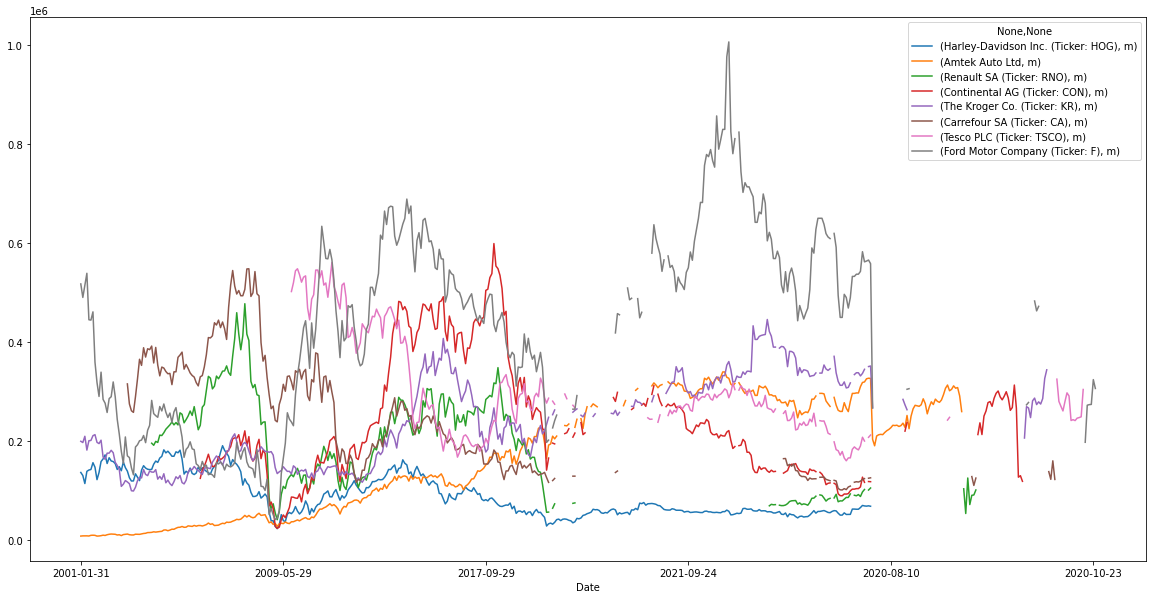

In [26]:
companies.plot(figsize=(20, 10))